In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
# http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [3]:
# Preparing data
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

# cleaning data
remove = []
c = train_data.columns
for i in range(len(c)-1):
    v = train_data[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,train_data[c[j]].values):
            remove.append(c[j])

train_data.drop(remove, axis=1, inplace=True)

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(train_data.drop(["TARGET","ID"],axis=1),
                                                  train_data.TARGET, 
                                                  random_state=0,
                                                  test_size=0.25)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


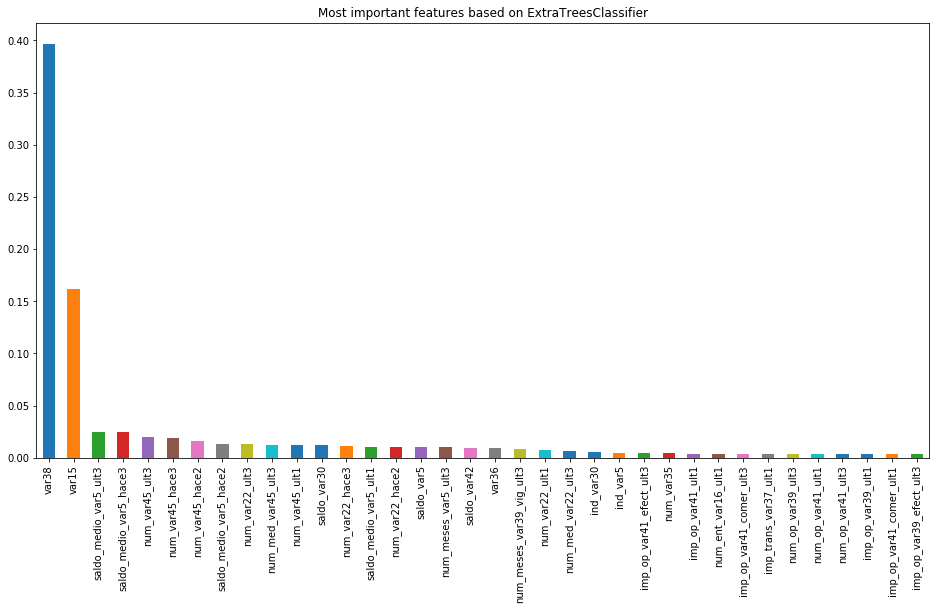

In [4]:
# Feature selection
# need to select the most important features
# will be using ExtraTreesClasifier for this task

feature_selection_model = ExtraTreesClassifier()
feature_selection_model.fit(train_X, train_y)
sel = SelectFromModel(feature_selection_model, prefit = True)

important_features = train_X.columns[(sel.get_support())]
# print(important_features)

feat_imp = pd.Series(feature_selection_model.feature_importances_, index = train_X.columns.values).sort_values(ascending=False)
feat_imp[:len(important_features)].plot(kind='bar', title='Most important features based on ExtraTreesClassifier', figsize=(16, 8))

In [5]:
#Finding best model with best hyperparameters
models1 = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'XGBClassifier': XGBClassifier()
}

params1 = {
    'ExtraTreesClassifier': { 'n_estimators': [64, 128, 256, 512, 1024] },
    'RandomForestClassifier': { 'n_estimators': [64, 128, 256, 512, 1024], 'min_samples_split': [2, 4, 8, 16] },
    'AdaBoostClassifier':  { 'n_estimators': [64, 128, 256, 512, 1024] },
    'GradientBoostingClassifier': { 'n_estimators': [64, 128, 256, 512, 1024], 'learning_rate': [0.8, 1.0] },
    'XGBClassifier': { 'n_estimators': [64, 128, 256, 512, 1024], 'max_depth': [1, 2, 3, 4, 5, 6]}
}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(train_X[important_features], train_y, scoring='roc_auc', n_jobs=2, refit= True)

helper1.score_summary(sort_by='mean_score')

Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  4.9min finished


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 14.7min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 20.4min finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  4.2min finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  5.2min finished


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed: 18.8min finished


ExtraTreesClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,min_score,mean_score,max_score,std_score,learning_rate,max_depth,min_samples_split,n_estimators
60,XGBClassifier,0.824345,0.833337,0.838034,0.00636023,NaN,5,NaN,64
55,XGBClassifier,0.824842,0.832912,0.837395,0.00571788,NaN,4,NaN,64
65,XGBClassifier,0.825226,0.832864,0.837256,0.00542131,NaN,6,NaN,64
51,XGBClassifier,0.823916,0.832651,0.837593,0.00619464,NaN,3,NaN,128
56,XGBClassifier,0.824016,0.83243,0.836938,0.00595448,NaN,4,NaN,128
50,XGBClassifier,0.823177,0.83191,0.837426,0.00624627,NaN,3,NaN,64
46,XGBClassifier,0.823136,0.831542,0.83773,0.00616114,NaN,2,NaN,128
47,XGBClassifier,0.823785,0.831253,0.835957,0.00533995,NaN,2,NaN,256
61,XGBClassifier,0.821107,0.8311,0.836938,0.00709956,NaN,5,NaN,128
52,XGBClassifier,0.821459,0.830064,0.834406,0.00608429,NaN,3,NaN,256


In [6]:
# Selecting the best estimator
clf = helper1.grid_searches.get('XGBClassifier').best_estimator_
print(helper1.grid_searches.get('XGBClassifier').best_params_)

{'max_depth': 5, 'n_estimators': 64}


In [7]:
#building final model and submitting to competition

#refit model with all train data
# clf = XGBClassifier(n_estimators=256, max_depth=1)
clf.fit(train_data.drop(["TARGET","ID"],axis=1)[important_features], train_data.TARGET)

submission_preds = clf.predict_proba(test_data[important_features])[:,1]

output = pd.DataFrame({'ID': test_data.ID,
                      'TARGET': submission_preds})
output.to_csv('submission.csv', index=False)